In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

In [2]:
train_folder = '/kaggle/input/indian-sign-language-isl/Indian'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,N,/kaggle/input/indian-sign-language-isl/Indian/...
1,N,/kaggle/input/indian-sign-language-isl/Indian/...
2,N,/kaggle/input/indian-sign-language-isl/Indian/...
3,N,/kaggle/input/indian-sign-language-isl/Indian/...
4,N,/kaggle/input/indian-sign-language-isl/Indian/...
...,...,...
42740,J,/kaggle/input/indian-sign-language-isl/Indian/...
42741,J,/kaggle/input/indian-sign-language-isl/Indian/...
42742,J,/kaggle/input/indian-sign-language-isl/Indian/...
42743,J,/kaggle/input/indian-sign-language-isl/Indian/...


In [3]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [4]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 30776 validated image filenames belonging to 35 classes.
Found 7694 validated image filenames belonging to 35 classes.
Found 4275 validated image filenames belonging to 35 classes.


In [5]:
base_model = ResNet50V2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
base_model.trainable = False ## Not trainable weights

2022-06-17 17:32:06.600747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 17:32:06.702037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 17:32:06.702835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 17:32:06.704042: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 1s 0us/step


In [6]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [7]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
prediction_layer = layers.Dense(35, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    prediction_layer
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2, 2, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 35)                17955     
Total params: 27,777,571
Trainable params: 4,212,771
Non-trainable params: 23,564,800
_________________________________________________________________


In [9]:
classes = 35
epochs = 10
learning_rate = 0.0001

adam = Adam(lr=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-06-17 17:32:12.156290: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-06-17 17:32:16.449846: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


241/241 [==============================] - 222s 887ms/step - loss: 0.2466 - accuracy: 0.9508 - val_loss: 8.8791e-04 - val_accuracy: 1.0000
Epoch 2/10
241/241 [==============================] - 82s 341ms/step - loss: 0.0043 - accuracy: 0.9995 - val_loss: 2.8110e-04 - val_accuracy: 1.0000
Epoch 3/10
241/241 [==============================] - 53s 220ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 1.2911e-04 - val_accuracy: 1.0000
Epoch 4/10
241/241 [==============================] - 53s 220ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 7.1860e-05 - val_accuracy: 1.0000
Epoch 5/10
241/241 [==============================] - 52s 214ms/step - loss: 5.7616e-04 - accuracy: 1.0000 - val_loss: 5.0488e-05 - val_accuracy: 1.0000
Epoch 6/10
241/241 [==============================] - 51s 211ms/step - loss: 4.2241e-04 - accuracy: 1.0000 - val_loss: 2.8469e-05 - val_accuracy: 1.0000
Epoch 7/10
241/241 [==============================] - 51s 212ms/step - loss: 2.9875e-04 - accuracy: 1.0000 -

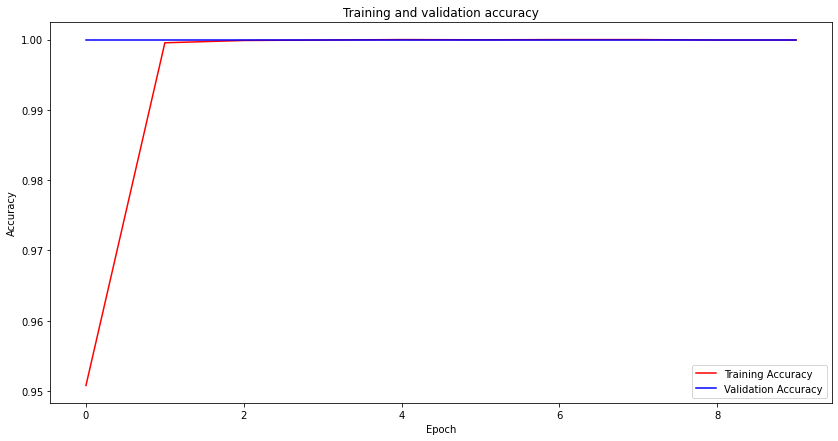

In [10]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

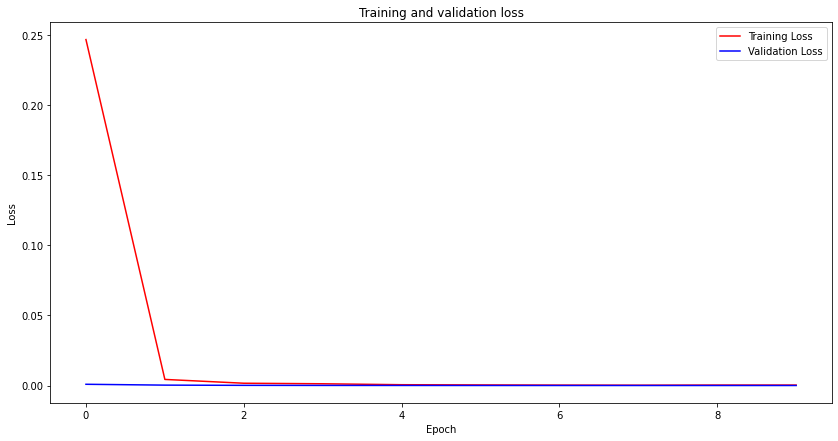

In [11]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [12]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

34/34 [==============================] - 24s 704ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       1.00      1.00      1.00       120
           5       1.00      1.00      1.00       120
           6       1.00      1.00      1.00       120
           7       1.00      1.00      1.00       120
           8       1.00      1.00      1.00       120
           9       1.00      1.00      1.00       120
           A       1.00      1.00      1.00       120
           B       1.00      1.00      1.00       120
           C       1.00      1.00      1.00       145
           D       1.00      1.00      1.00       120
           E       1.00      1.00      1.00       120
           F       1.00      1.00      1.00       120
           G       1.00      1.00      1.00       120
           H       1.00  

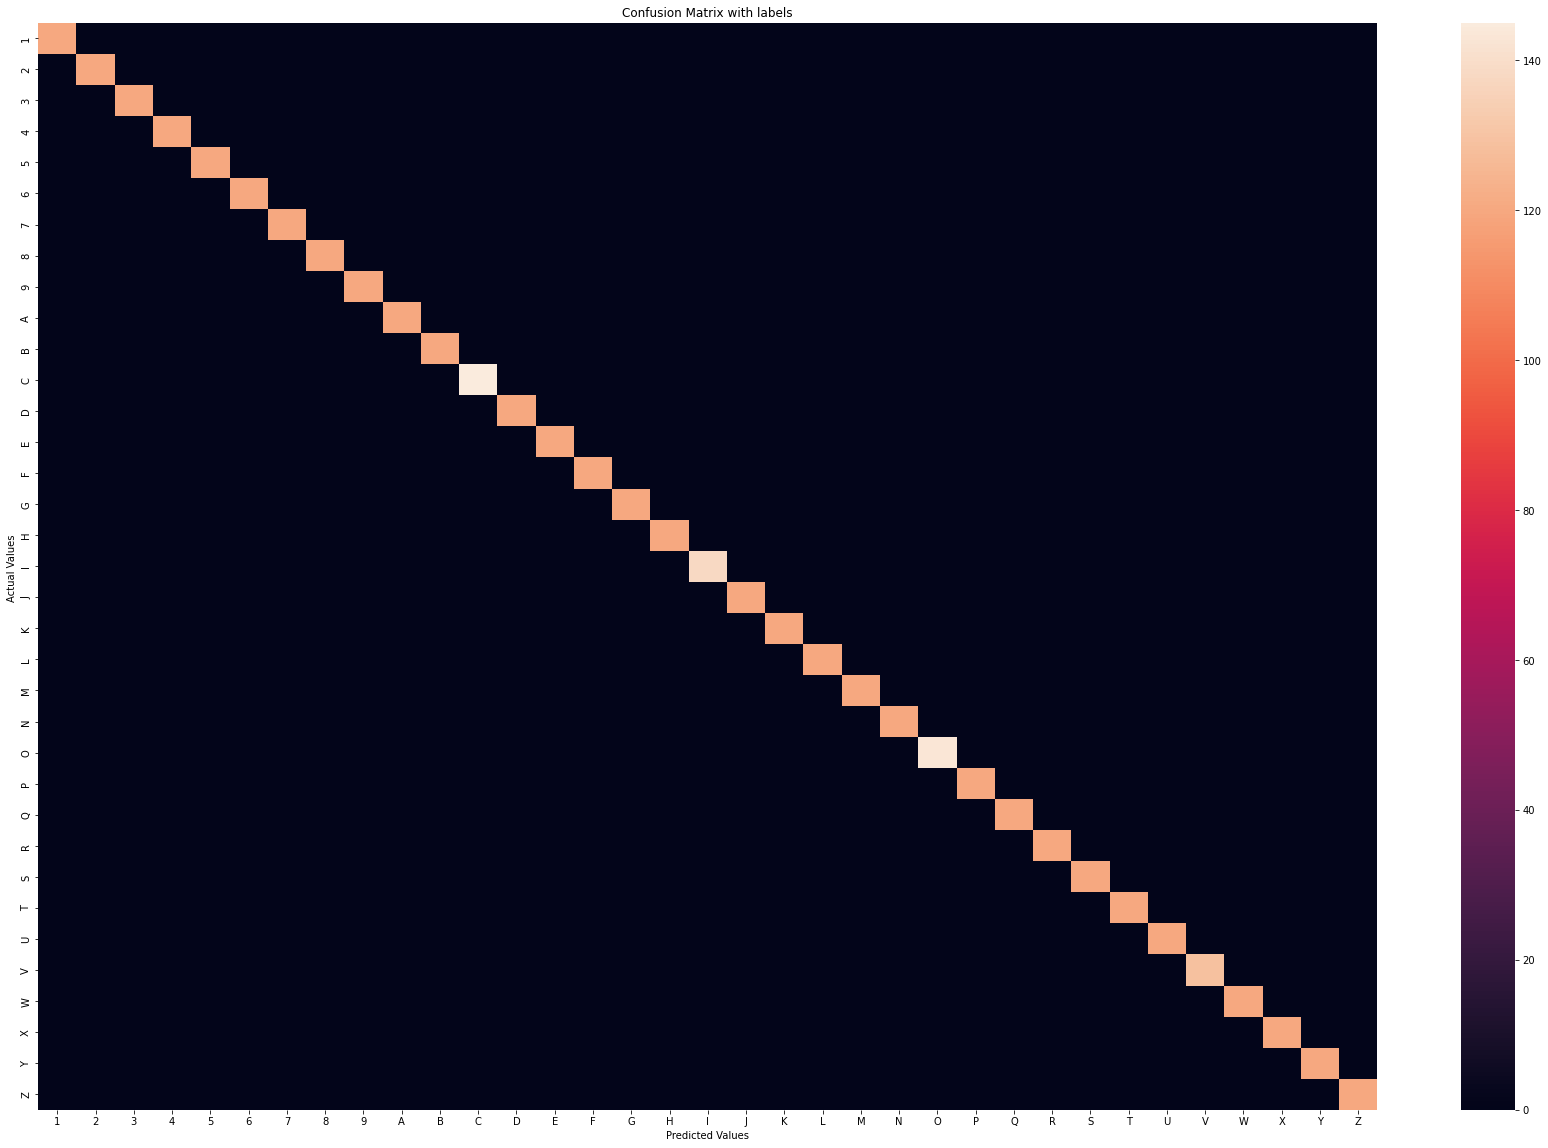

In [13]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [14]:
model.save('ISLResNet50V2.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
